# Attention Architecture

In [5]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [6]:
import music21
import torch

from fastai.distributed import *
from fastai.text.models.transformer import *

import numpy as np

from fastai_data import *
from lmnp_transformer import *
from encode_data import *

In [7]:
np.set_printoptions(edgeitems=10, threshold=40, linewidth=200)

### Requests

In [10]:
BASE_URL = "http://localhost:6006"

In [11]:
requests.post(f'{BASE_URL}/hello')


<Response [200]>

### Old

In [4]:
bs=16
bptt=256

In [5]:
transpose_tfm = partial(rand_transpose, enc_offset=ENC_OFFSET, rand_range=(0,12))

In [6]:
path = Path('data/midi/v9/midi_encode/np/shortdur/')
data = LMNPDataBunch.load(path, bs=bs, bptt=bptt, cache_name='tmp/hook', train_tfms=[transpose_tfm])

In [7]:
VOCAB_SZ = create_vocab_sizes(path/'tmp/all')
N_COMPS = len(VOCAB_SZ)
N_EMBS = 128
EMB_IDXS = range(N_COMPS)
EMB_DIM = [N_EMBS]*len(EMB_IDXS)
EMB_MAP = list(zip(EMB_IDXS,VOCAB_SZ,EMB_DIM))
EMB_MAP

[(0, 130, 128), (1, 132, 128)]

In [8]:
idx2embidx = { i:EMB_MAP[i] for i in range(N_COMPS) }
total_embs = sum([v[-1] for k,v in idx2embidx.items()])

In [9]:
config = tfmerXL_lm_config
config['emb_map'] = list(zip(EMB_IDXS,VOCAB_SZ,EMB_DIM))
config['idx_map'] = idx2embidx
config['loss_weights'] = [1,1] # note,duration
config['pad_idx'] = PADDING_IDX+ENC_OFFSET
config['bos_idx'] = VALTBOS+ENC_OFFSET
config['mask_type'] = MaskType.RandomWindow
config['act'] = Activation.ReLU

config['d_model'] = total_embs
config['mem_len'] = 512

config['resid_p'] = 0.1
config['attn_p'] = 0.1 # attention dropout
config['ff_p'] = 0.1
config['embed_p'] = 0.1 # embedding dropout
config['output_p'] = 0.1 # decoder dropout (before final linear layer)
config

{'ctx_len': 150,
 'n_layers': 12,
 'n_heads': 10,
 'd_model': 256,
 'd_head': 41,
 'd_inner': 2100,
 'resid_p': 0.1,
 'attn_p': 0.1,
 'ff_p': 0.1,
 'embed_p': 0.1,
 'output_p': 0.1,
 'bias': False,
 'scale': True,
 'act': <Activation.ReLU: 1>,
 'double_drop': True,
 'tie_weights': True,
 'out_bias': True,
 'init': <function fastai.text.models.transformer.init_transformer(m)>,
 'mem_len': 512,
 'mask': True,
 'emb_map': [(0, 130, 128), (1, 132, 128)],
 'idx_map': {0: (0, 130, 128), 1: (1, 132, 128)},
 'loss_weights': [1, 1],
 'pad_idx': 0,
 'bos_idx': 2,
 'mask_type': <MaskType.RandomWindow: 3>}

In [10]:
learn = language_model_learner(data, config, clip=0.25)

In [11]:
x,y = data.one_batch(cpu=False)

In [12]:
models = get_files(path/'models/hook', recurse=True); models

[PosixPath('data/midi/v9/midi_encode/np/shortdur/models/hook/1_epoch20_best.pth'),
 PosixPath('data/midi/v9/midi_encode/np/shortdur/models/hook/v9_1_epoch20_best.pth'),
 PosixPath('data/midi/v9/midi_encode/np/shortdur/models/hook/v9_2_epoch30_best.pth'),
 PosixPath('data/midi/v9/midi_encode/np/shortdur/models/hook/v9_1_epoch20.pth'),
 PosixPath('data/midi/v9/midi_encode/np/shortdur/models/hook/1_epoch20.pth'),
 PosixPath('data/midi/v9/midi_encode/np/shortdur/models/hook/v9_2_epoch30.pth')]

In [13]:
# load_path = Path('data/midi/v9/midi_encode/np/shortdur/models/pop/v9_2_epoch30_best.pth')
load_path = Path('data/midi/v9/midi_encode/np/shortdur/models/hook/v9_2_epoch30_best.pth')
state = torch.load(load_path, map_location='cpu')
get_model(learn.model).load_state_dict(state['model'], strict=False)

### From batch

In [14]:
xb,yb = learn.data.one_batch(cpu=False)

### From song

In [15]:
seed_len = 60
files = get_files(path/'hooktheory', extensions=['.npy'], recurse=True)

In [16]:
# Loading from specific file
keywords = 'country road'.split(' ')
def contains_keywords(f): return all([k in str(f) for k in keywords])
search = [f for f in files if contains_keywords(f)]; search

[PosixPath('data/midi/v9/midi_encode/np/shortdur/hooktheory/pianoroll/j/john-denver/take-me-home-country-roads/bridge_key_cmajor.npy'),
 PosixPath('data/midi/v9/midi_encode/np/shortdur/hooktheory/pianoroll/j/john-denver/take-me-home---country-roads/chorus_key_cmajor.npy')]

In [17]:
# file = np.random.choice(files)
file = search[-1]
file

PosixPath('data/midi/v9/midi_encode/np/shortdur/hooktheory/pianoroll/j/john-denver/take-me-home---country-roads/chorus_key_cmajor.npy')

In [18]:
#good_one = Path('data/midi/v7/midi_encode/np/hook_1bar_nopos/hooktheory/c/cool-and-new-web-comic/tick---tock/chorus.npy')
# file = Path('data/midi/v9/midi_encode/np/shortdur/hooktheory/pianoroll/r/ritchie-valen/la-bamba/chorus_key_cmajor.npy')
# third_eye = Path('data/midi/v7/midi_encode/np/hook_1bar_nopos/hooktheory/t/third-eye-blind/semi-charmed-life/chorus.npy')

In [19]:
song_np = np.load(file)
seed_np = np.load(file)[:seed_len]
xb = torch.tensor(seed_np)[None]

### Predict

In [20]:
# out, seed = learn.predict(xb, n_words=340, temperature=1, min_p=0.01)

In [21]:
# Higher temperature = More randomness (1.5)
# Lower temperature = Less random (.5)

In [22]:
out, seed = learn.predict(xb, n_words=340, temperatures=(1.5,0.9), min_ps=(1/128,0.0))

Predicted BOS token. Returning prediction...


### Actual prediction

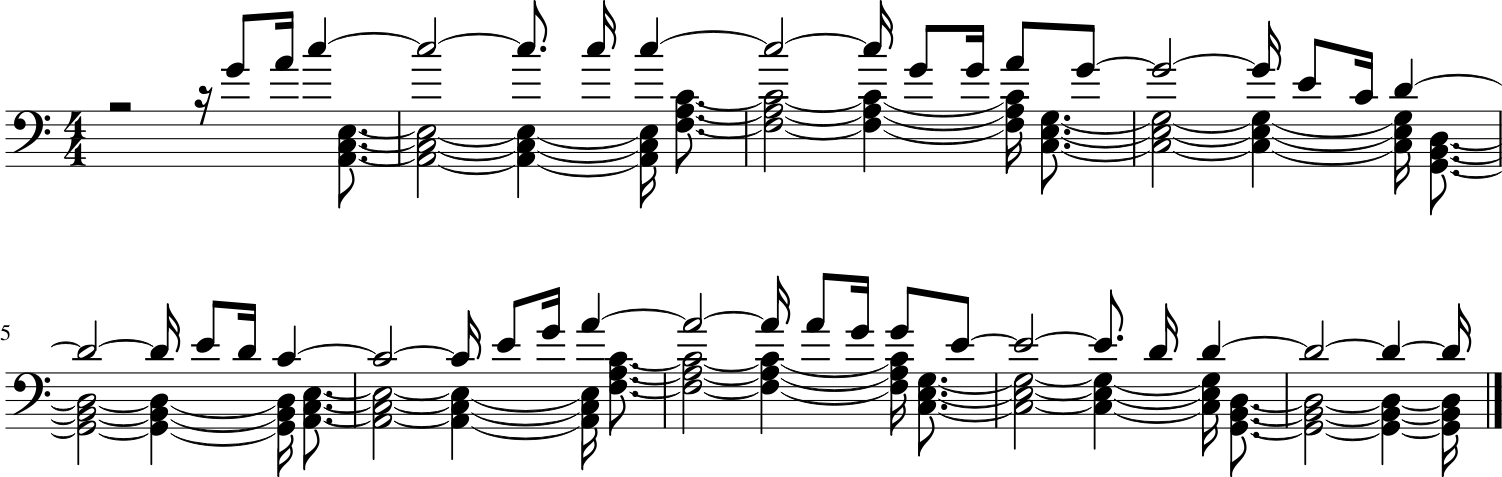

In [23]:
stream = npenc2stream(out)
stream.show()

In [24]:
stream.show('midi')

## Seed

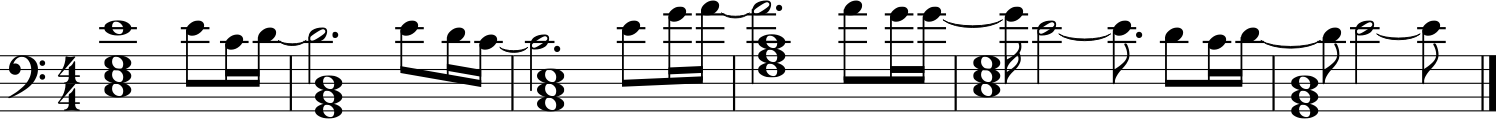

In [25]:
seed_stream = npenc2stream(seed)
seed_stream.show()

In [26]:
seed_stream.show('midi')

## Alltogether now

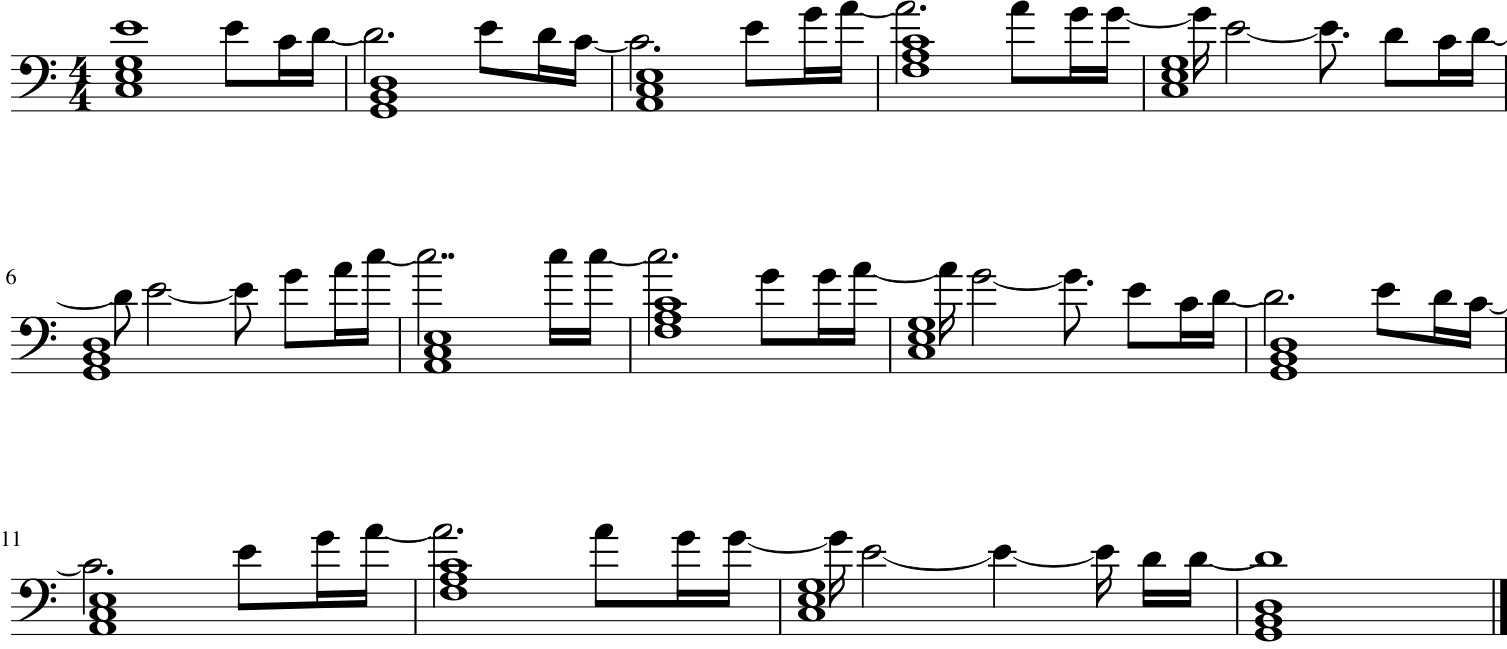

In [27]:
full_output = np.concatenate((seed,out), axis=0)
full_stream = npenc2stream(full_output)
full_stream.show()

In [28]:
full_stream.show('midi')

### Original

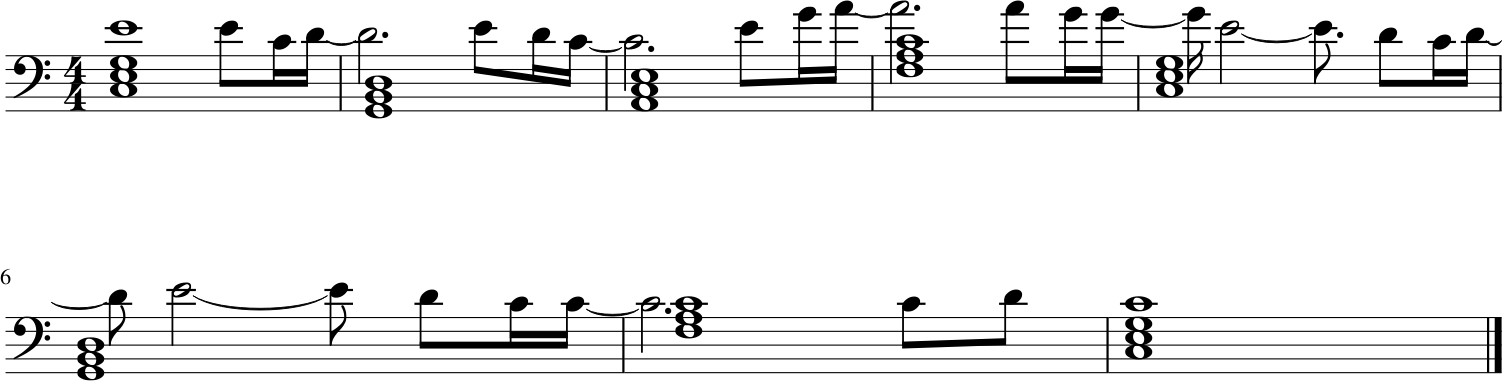

In [29]:
original_stream = npenc2stream(song_np)
original_stream.show()

In [30]:
original_stream.show('midi')

## Flask App

In [32]:
from flask import Flask, Response

app = Flask(__name__)

@app.route('/hello/', methods=['GET', 'POST'])
def hello_world():
    return 'Hello, World!'

@app.route('/predict')
def predict():
    out, seed = learn.predict(learn, xb, n_words=340, temperatures=(1.5,0.9), min_ps=(1/128,0.0))
    
    feature1 = request.args.get('feature1')
    feature2 = request.args.get('feature2')
    feature3 = request.args.get('feature3')
    input = [feature1, feature2, feature3]
    prediction = model.predict(input)
    result = dict({
        'prediction': prediction
    })
    return jsonify(result)

@app.route('/health')
def health_check():
    return Response("", status = 200)

# if __name__ == '__main__':
#     app.run(debug=True,host='0.0.0.0')

In [ ]:
from werkzeug.serving import run_simple
run_simple('localhost', 9000, app)